In [12]:
import pandas as pd
import numpy as np

import seaborn as sns
#sns.set(rc={'figure.figsize':(20, 12)})
sns.set_theme(style="whitegrid")

pd.set_option("display.max_rows", None, "display.max_columns", None)

import warnings
warnings.filterwarnings("ignore")

In [13]:
import dataset
import analysis

In [14]:
k_data_path = '../generate_data/data/thres_inf/'
k_train_dates = [
    #'2020-06-30',
    '2020-09-30',
    '2020-12-31',
    '2021-03-31',
    '2021-06-30',
    #'2021-09-30',
]

k_test_dates = ['2021-09-30']

k_cutpoints = [-0.3, -0.1, 0.1, 0.3]
k_stocks_only = '.SH'

In [15]:
args = dataset.Args(data_path   = k_data_path,
                    train_dates = k_train_dates,
                    test_dates  = k_test_dates,
                    classifier_cut_points = k_cutpoints,
                    stocks_only = k_stocks_only,
                    )
ds = dataset.DataSet.create(args)

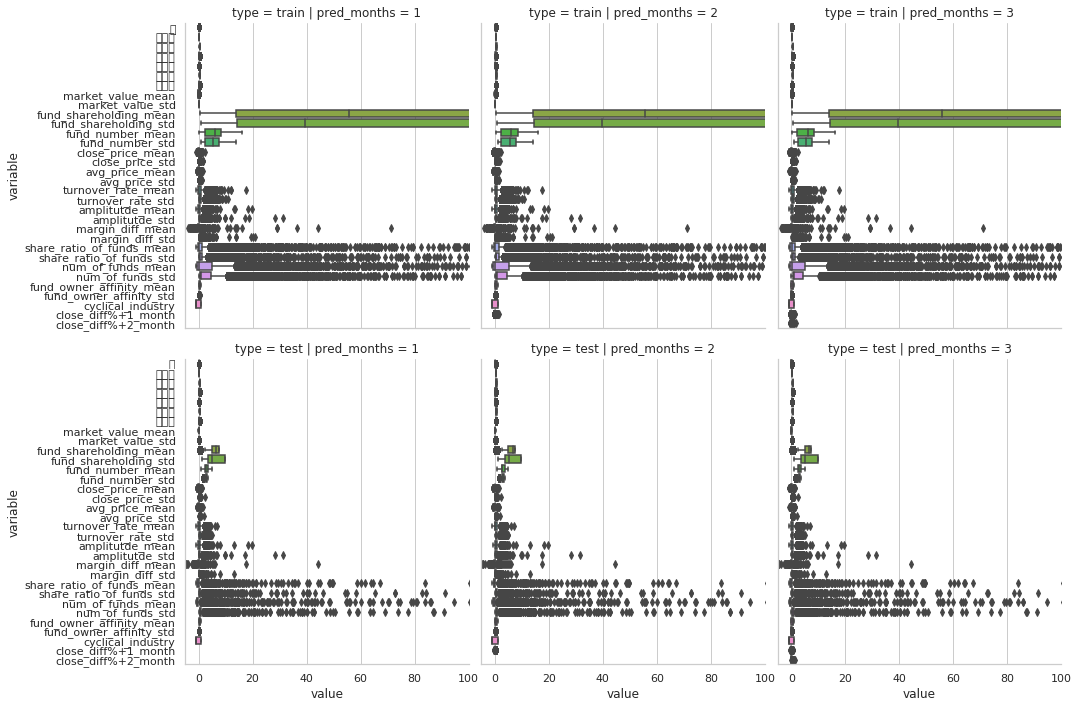

In [16]:
data = []
for months, d in ds.items():
    x_train = d.x_train.melt()
    x_train['type']         = 'train'
    x_train['pred_months']  = months
    data.append(x_train)

    x_test = d.x_test.melt()
    x_test['type']         = 'test'
    x_test['pred_months']  = months
    data.append(x_test)
data = pd.concat(data).reset_index(drop=True)

g = sns.catplot(kind    = 'box',
                x       = 'value',
                y       = 'variable',
                col     = 'pred_months',
                row     = 'type',
                data    = data)
g.set(xlim=(-5, 100))
g


In [17]:
def plot_indicator_dist(data,
        variable = None,
        xlim = None,
        ylim = (0, None),
        min_val = None,
        max_val = None,
        **kwargs):

    cond = []
    if variable is not None:
        if isinstance(variable, (list, tuple)):
            cond.append(data.variable.apply(lambda x : x in variable))
        else:
            cond.append(data.variable == variable)
    if max_val is not None:
        cond.append(data['value'] <= max_val)
    if min_val is not None:
        cond.append(data['value'] >= min_val)
    where = np.logical_and.reduce(cond)

    g = sns.displot(kind    = 'hist',
                    x       = 'value',
                    row     = 'variable',
                    col     = 'pred_months',
                    hue     = 'type',
                    data    = data[where],
                    **kwargs)
    g.set(xlim=xlim, ylim=ylim)
    return g

In [21]:
indicators = data.variable.unique()
indicators.sort()
indicators

array(['amplitutde_mean', 'amplitutde_std', 'avg_price_mean',
       'avg_price_std', 'close_diff%+1_month', 'close_diff%+2_month',
       'close_price_mean', 'close_price_std', 'cyclical_industry',
       'fund_number_mean', 'fund_number_std', 'fund_owner_affinity_mean',
       'fund_owner_affinity_std', 'fund_shareholding_mean',
       'fund_shareholding_std', 'margin_diff_mean', 'margin_diff_std',
       'market_value_mean', 'market_value_std', 'num_of_funds_mean',
       'num_of_funds_std', 'share_ratio_of_funds_mean',
       'share_ratio_of_funds_std', 'turnover_rate_mean',
       'turnover_rate_std', '中盘股', '价值型', '大盘股', '小盘股', '成长型', '是', '混合型'],
      dtype=object)

In [22]:
mean_indicators = [ind for ind in indicators if ind.endswith('_mean')]
std_indicators  = [ind for ind in indicators if ind.endswith('_std')]
rem_indicators  = [ind for ind in indicators if ind not in mean_indicators + std_indicators]

plotting indicator: amplitutde_mean


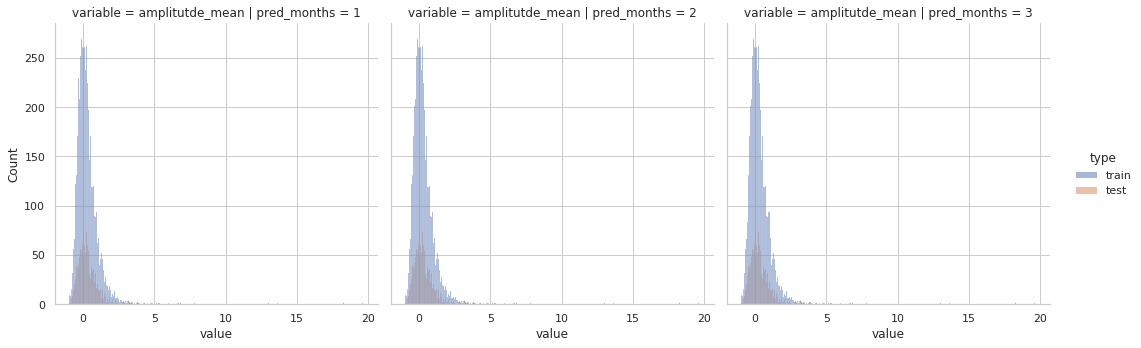

plotting indicator: avg_price_mean


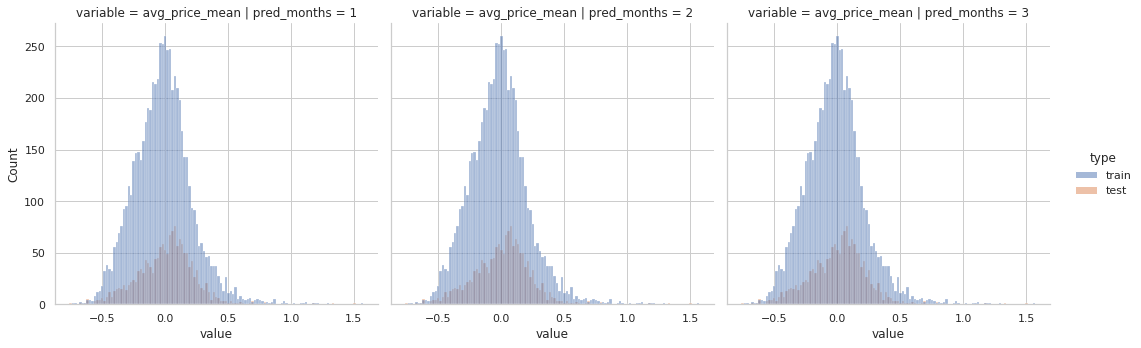

plotting indicator: close_price_mean


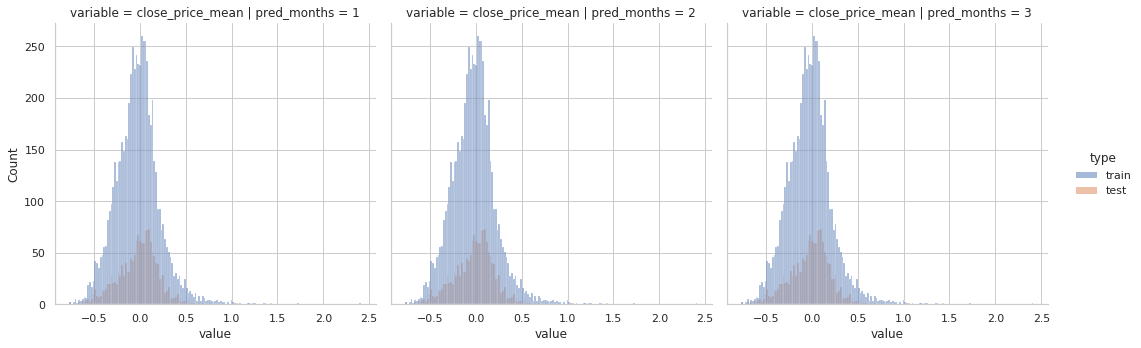

plotting indicator: fund_number_mean


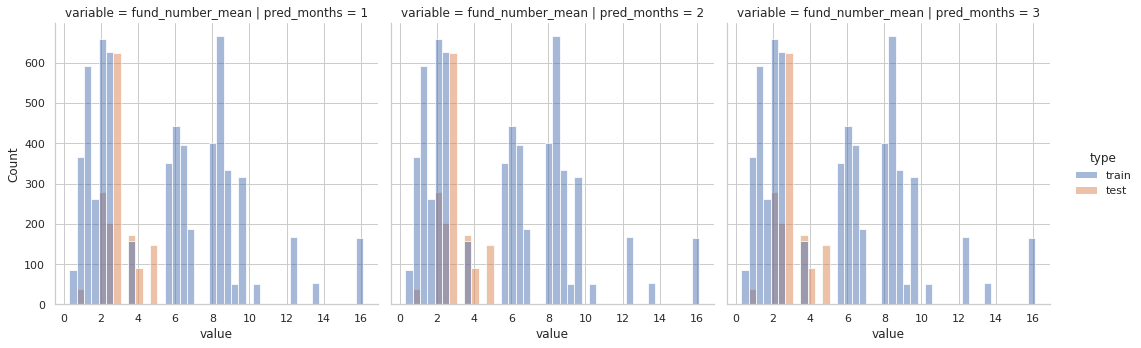

plotting indicator: fund_owner_affinity_mean


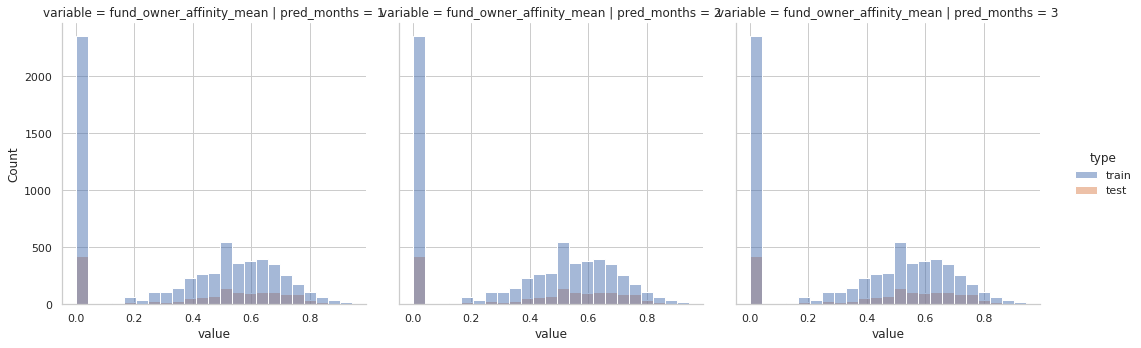

plotting indicator: fund_shareholding_mean


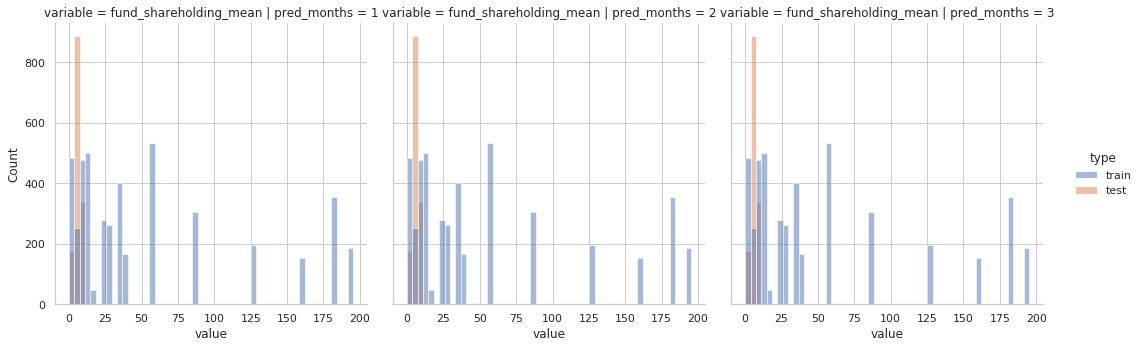

plotting indicator: margin_diff_mean


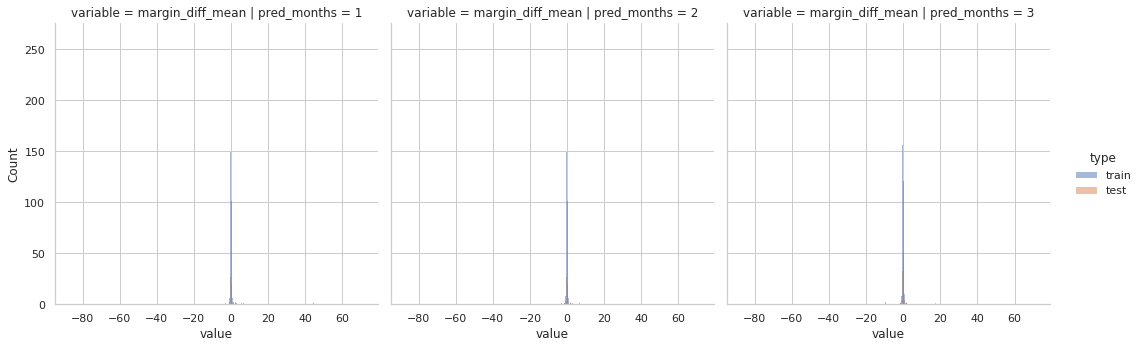

plotting indicator: market_value_mean


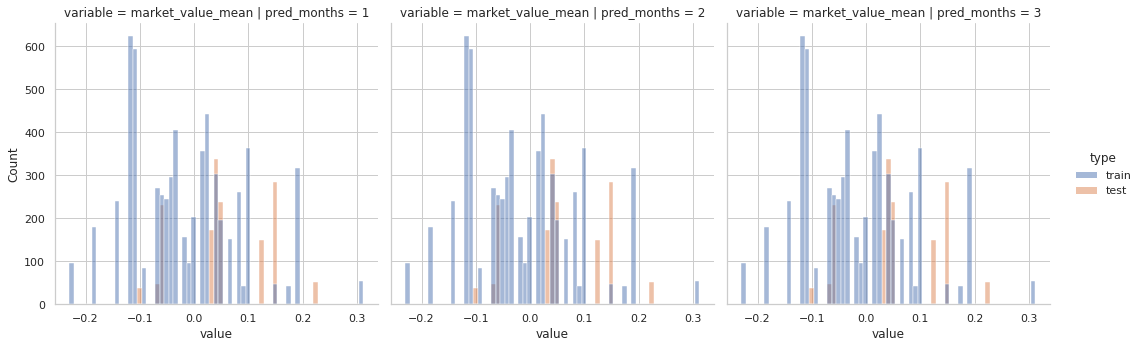

plotting indicator: num_of_funds_mean


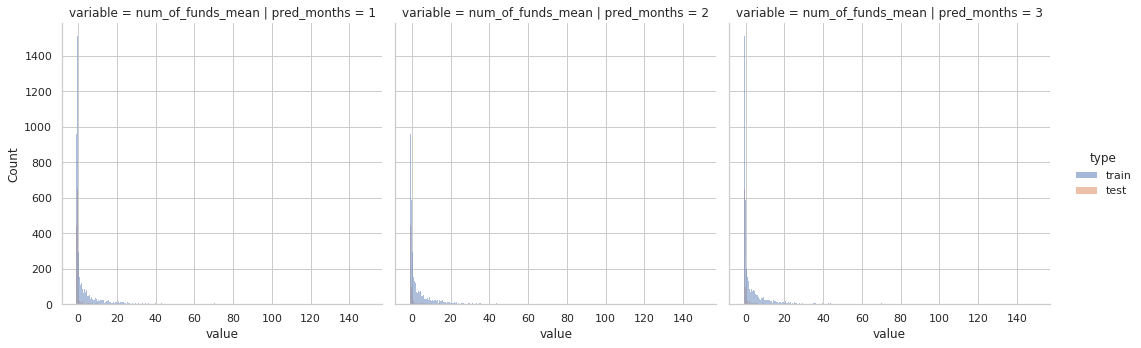

plotting indicator: share_ratio_of_funds_mean


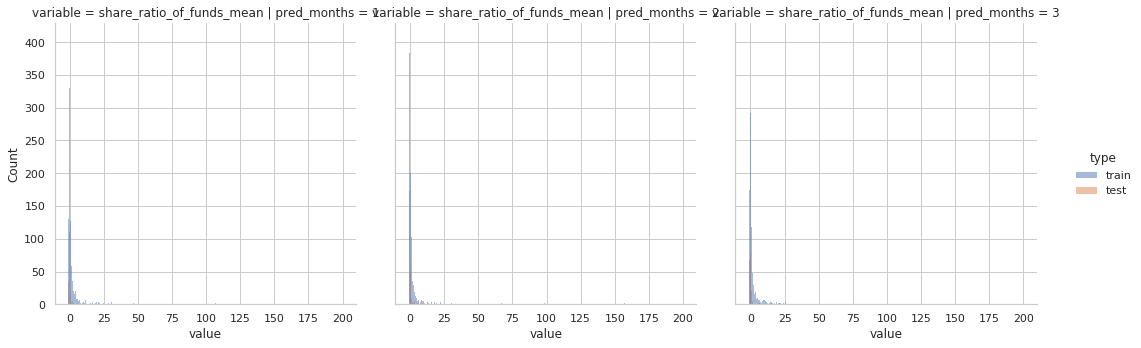

plotting indicator: turnover_rate_mean


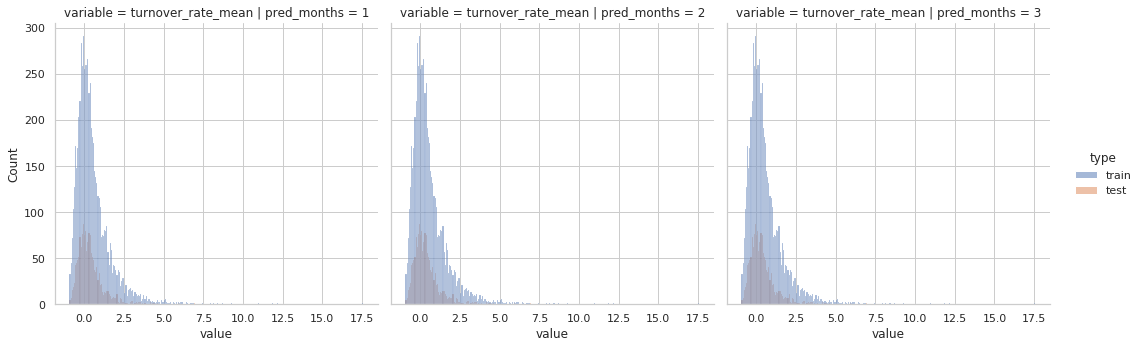

In [23]:
import matplotlib.pyplot as plt

for ind in mean_indicators:
    print(f'plotting indicator: {ind}')
    plot_indicator_dist(data, variable=ind, min_val=-200, max_val=200)
    plt.show()

plotting indicator: amplitutde_std


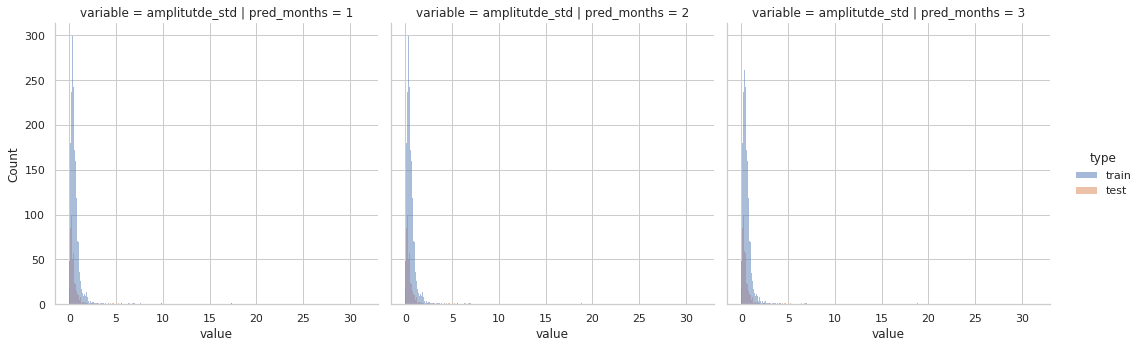

plotting indicator: avg_price_std


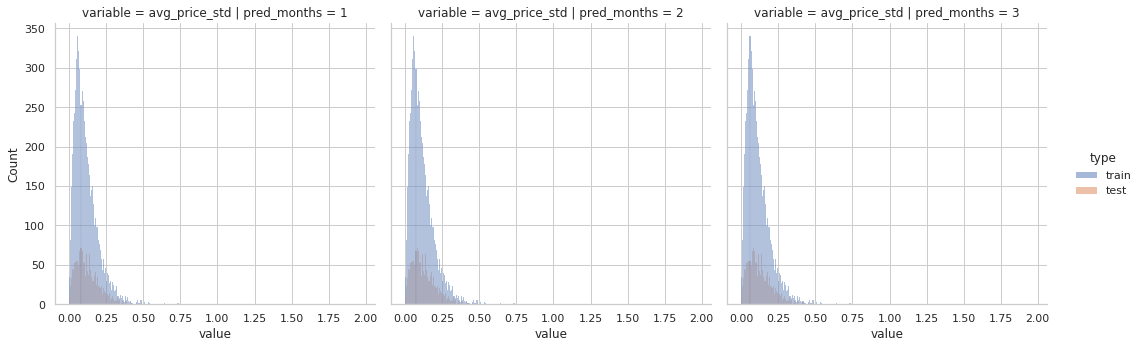

plotting indicator: close_price_std


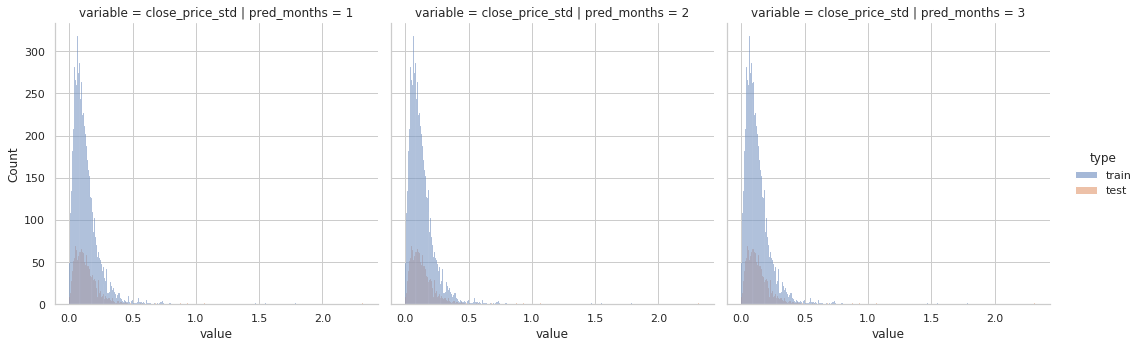

plotting indicator: fund_number_std


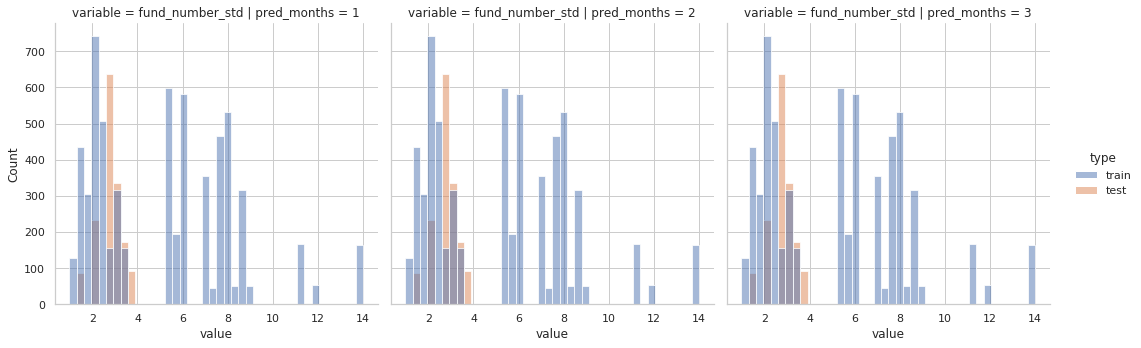

plotting indicator: fund_owner_affinity_std


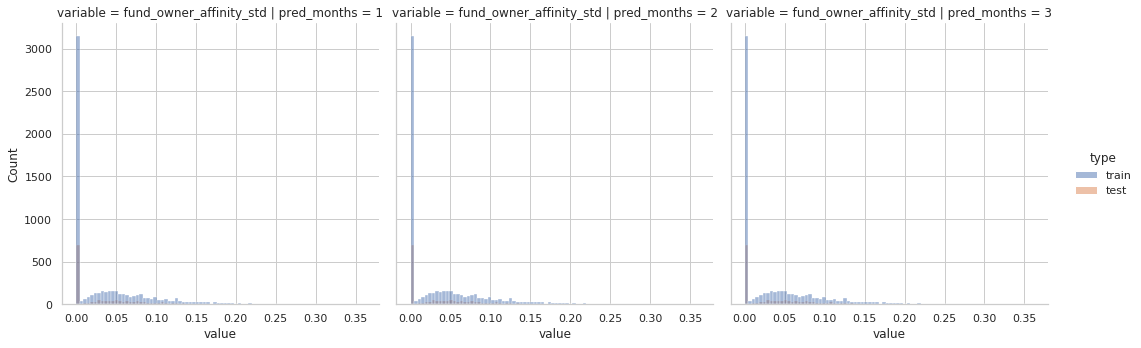

plotting indicator: fund_shareholding_std


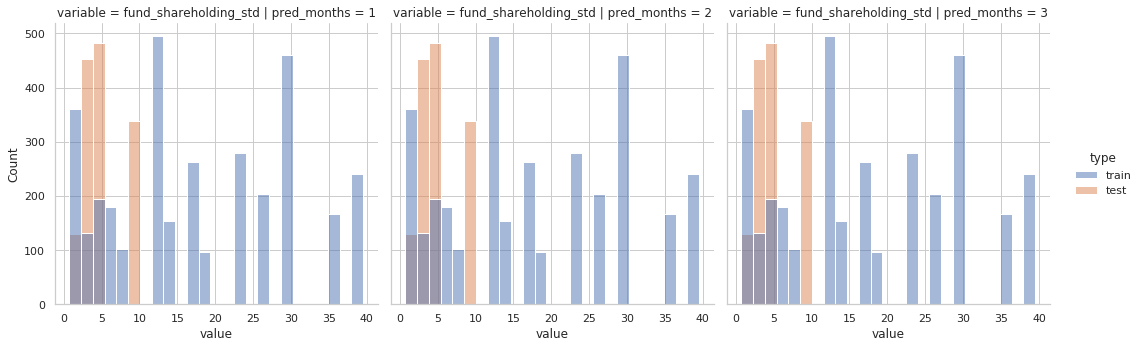

plotting indicator: margin_diff_std


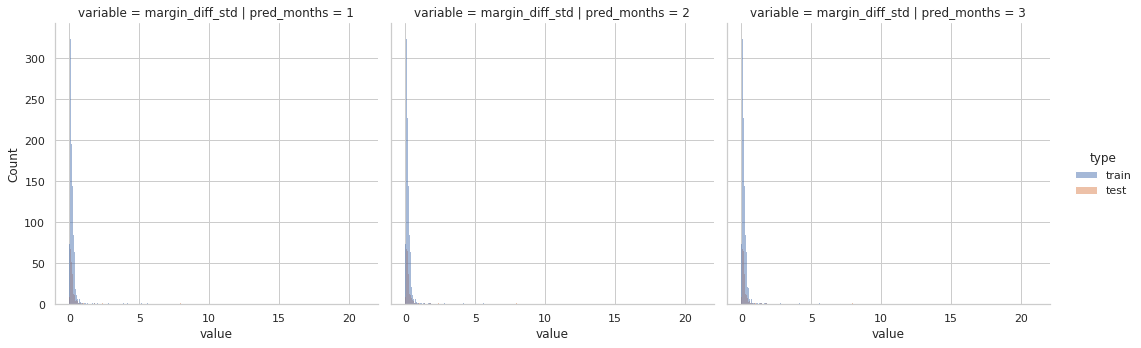

plotting indicator: market_value_std


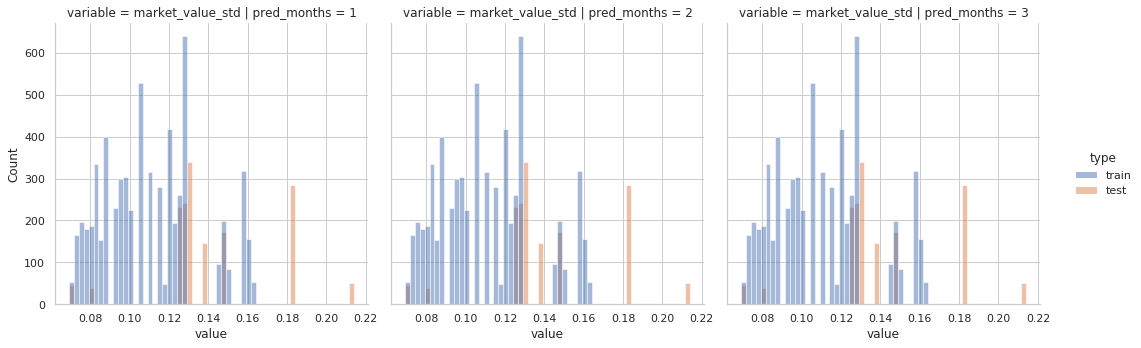

plotting indicator: num_of_funds_std


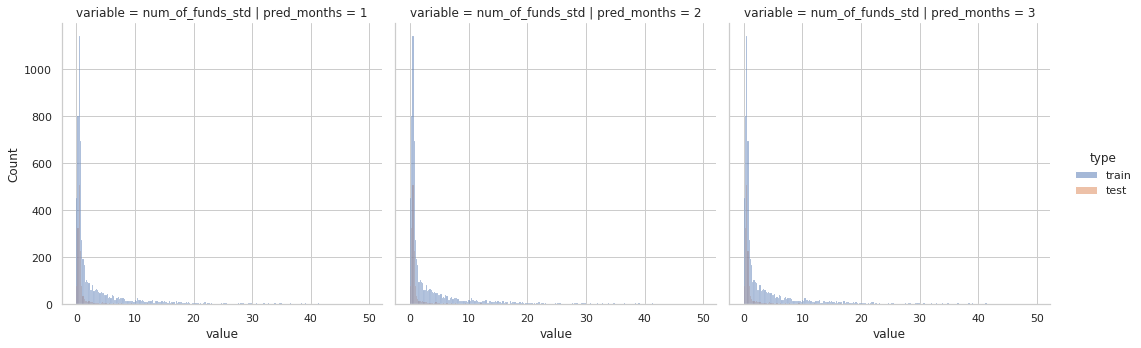

plotting indicator: share_ratio_of_funds_std


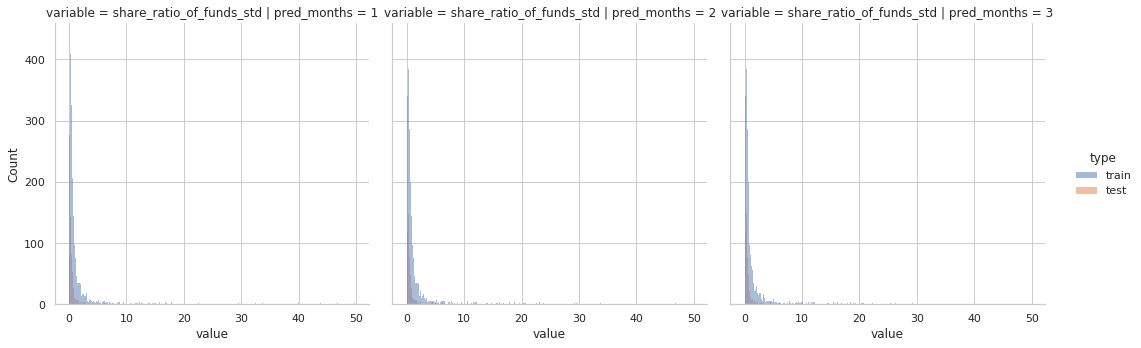

plotting indicator: turnover_rate_std


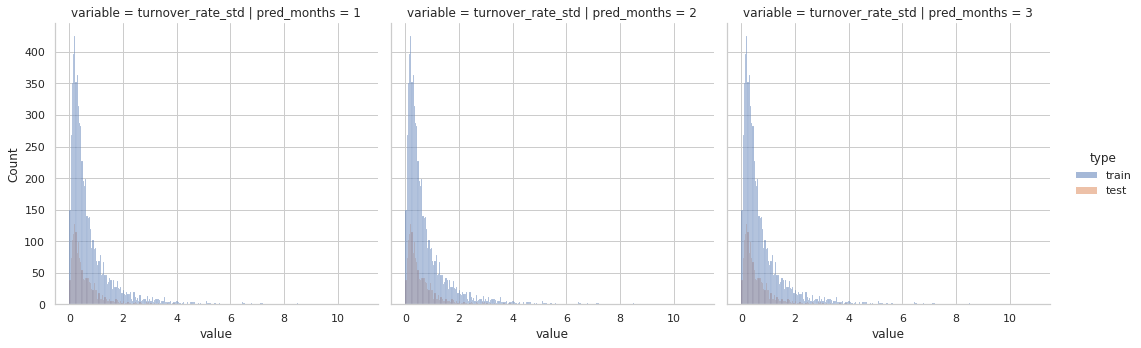

In [24]:
for ind in std_indicators:
    print(f'plotting indicator: {ind}')
    plot_indicator_dist(data, variable=ind, min_val=-50, max_val=50)
    plt.show()

plotting indicator: close_diff%+1_month


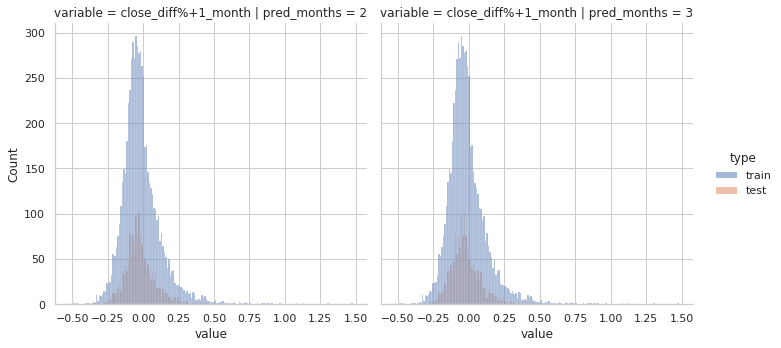

plotting indicator: close_diff%+2_month


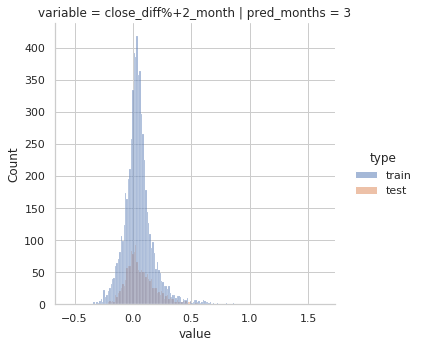

plotting indicator: cyclical_industry


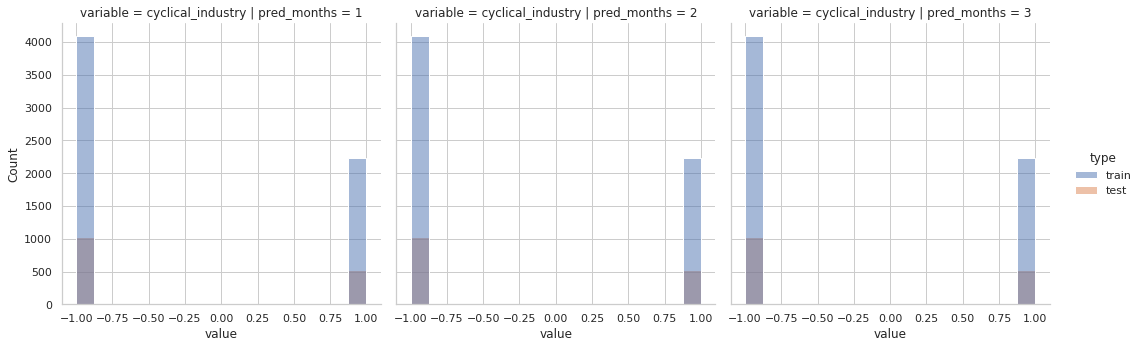

plotting indicator: 中盘股


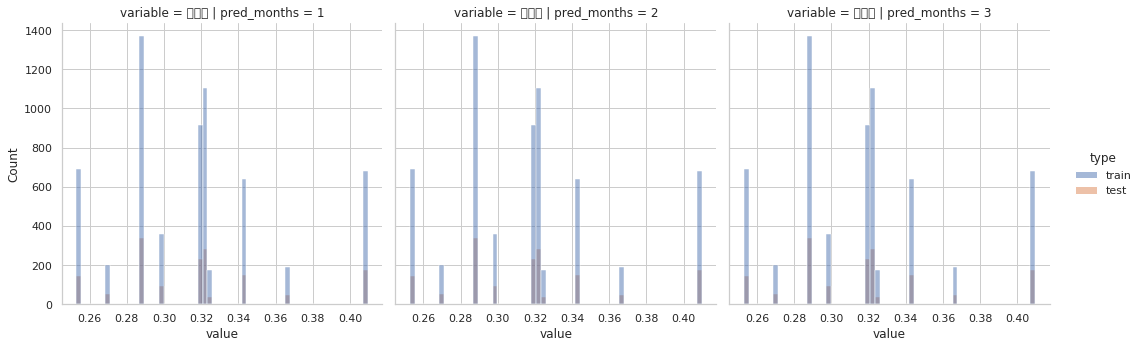

plotting indicator: 价值型


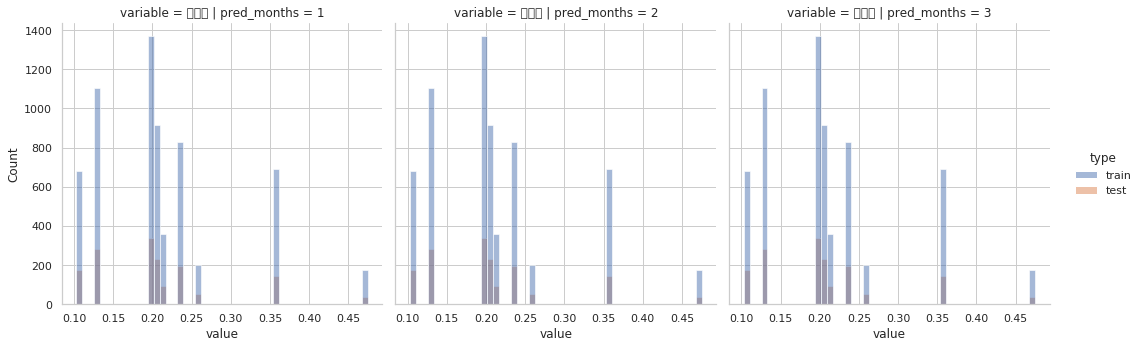

plotting indicator: 大盘股


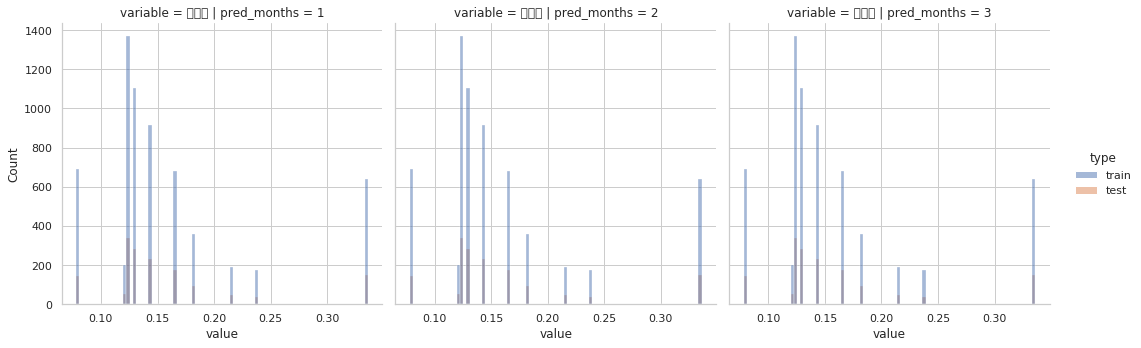

plotting indicator: 小盘股


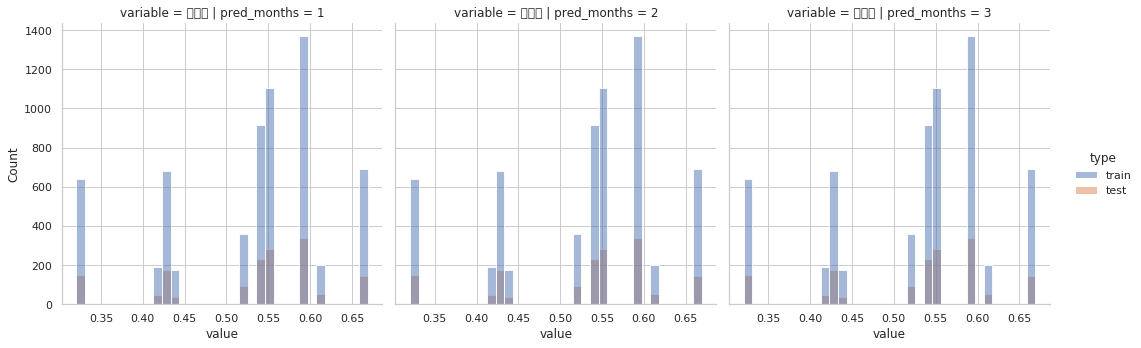

plotting indicator: 成长型


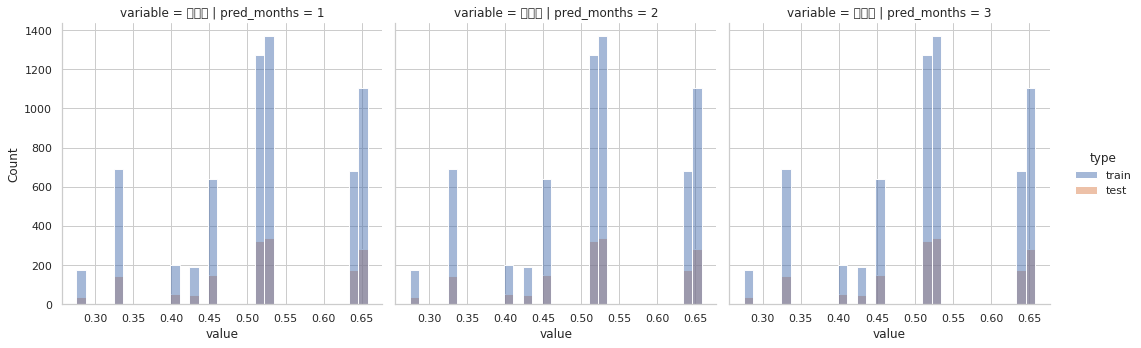

plotting indicator: 是


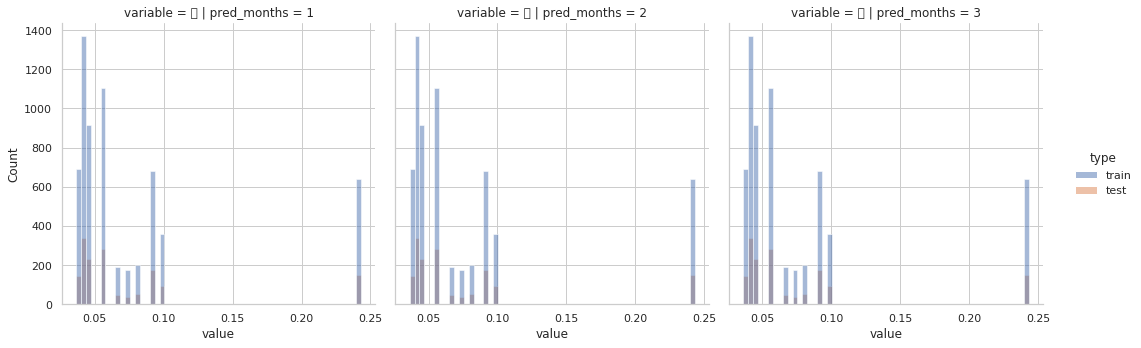

plotting indicator: 混合型


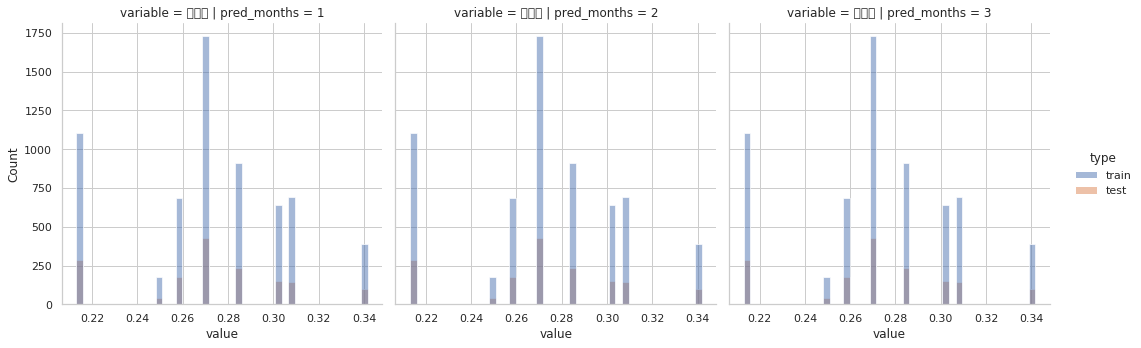

In [25]:
for ind in rem_indicators:
    print(f'plotting indicator: {ind}')
    plot_indicator_dist(data, variable=ind, min_val=-200, max_val=200)
    plt.show()

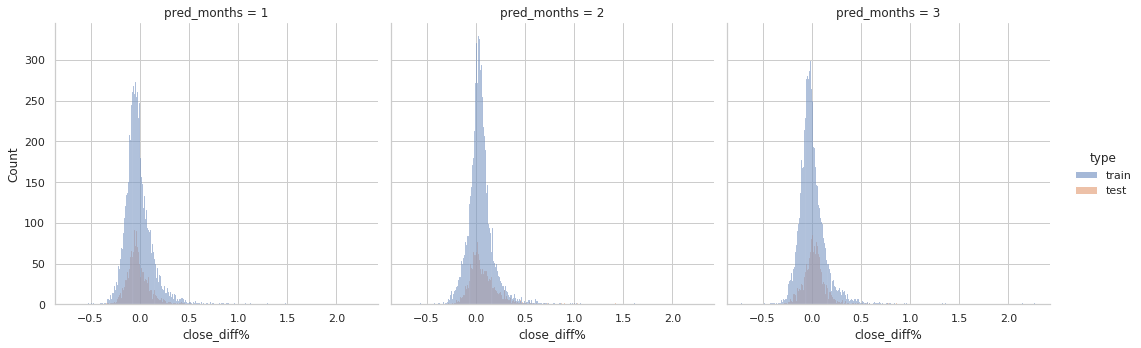

In [27]:
data = []
for months, d in ds.items():
    y_train = pd.DataFrame()
    y_train['close_diff%']  = d.y_train
    y_train['type']         = 'train'
    y_train['pred_months']  = months
    data.append(y_train)

    y_test = pd.DataFrame()
    y_test['close_diff%']  = d.y_test
    y_test['type']         = 'test'
    y_test['pred_months']  = months
    data.append(y_test)
data = pd.concat(data, ignore_index=True)

g = sns.displot(data = data,
                x    = 'close_diff%',
                col  = 'pred_months',
                hue  = 'type',
                )
g

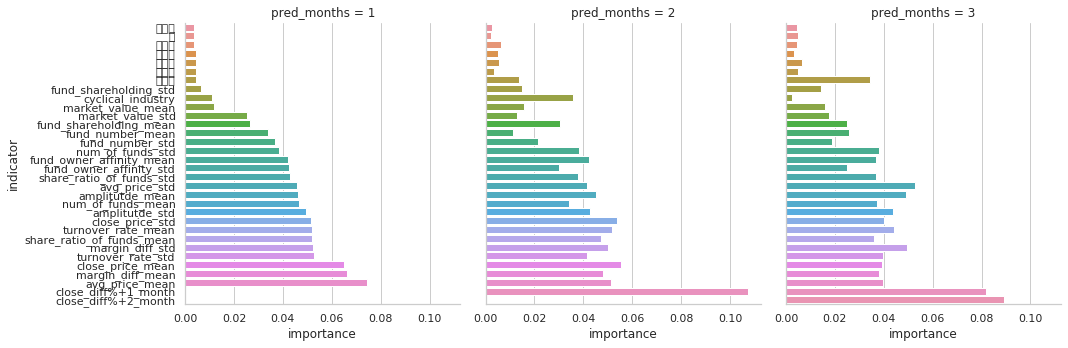

In [7]:
data = []
for months, d in ds.items():
    imp = analysis.compute_feature_importance(d)
    imp['pred_months'] = months
    data.append(imp)

data = pd.concat(data)

g = sns.catplot(kind    = 'bar',
                x       = 'importance',
                y       = 'indicator',
                col     = 'pred_months',
                data    = data)
g